## Analyse chances to get to Faculty of Computer Science
Analyse based on a pdf with total candidates and confirmed places what is your chance to get accepted

In [1]:
# Importing the required libraries
import pandas as pd
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from colorthief import ColorThief
import camelot

## Extract confirmations of diploma for informatica buget

In [2]:
from pdf2image import convert_from_path
pdf_path = "pdfs/ListeInformatica_24.07.pdf"
pdf_images = convert_from_path(pdf_path)

In [3]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [9]:
def check_admitted(image):
    temp_path = "pdfs/tmp_page_cell.jpg"
    cv2.imwrite(temp_path, image)
    color_thief = ColorThief(temp_path)
    dominant_color = color_thief.get_color(quality=1)
    if dominant_color == (189,189,189) or dominant_color == (190, 190, 190):
        return 1
    return 0

In [10]:
def compute_confirmation_places_ocr(pdf_images):
    diploma_confirmation_all_pages = []
    
    # will go trough all the pages to ocr confirmation of places
 

    for pdf_image in pdf_images:
        pdf_image.save("pdfs/tmp_page.jpg", 'JPEG')
        table_img = cv2.imread("pdfs/tmp_page.jpg", 0)

        thresh,img_bin = cv2.threshold(table_img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

        #inverting the image 
        img_bin = 255-img_bin
        cv2.imwrite('pdfs/tmp_page_inverted.jpg',img_bin)
        # Plotting the image to see the output
        # plotting = plt.imshow(img_bin,cmap='gray')
        # plt.show()

        # Length(width) of kernel as 100th of total width
        kernel_len = np.array(table_img).shape[1]//100
        # Defining a vertical kernel to detect all vertical lines of image 
        ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
        # Defining a horizontal kernel to detect all horizontal lines of image
        hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
        # A kernel of 2x2
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

        #Use vertical kernel to detect and save the vertical lines in a jpg
        image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
        vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
        cv2.imwrite("pdfs/tmp_page_vertical.jpg",vertical_lines)
        #Plot the generated image
        #plotting = plt.imshow(image_1,cmap='gray')
        #plt.show()

        #Use horizontal kernel to detect and save the horizontal lines in a jpg
        image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
        horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
        cv2.imwrite("pdfs/tmp_page_horizontal.jpg",horizontal_lines)

        # Combine horizontal and vertical lines in a new third image, with both having same weight.
        img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
        #Eroding and thesholding the image
        img_vh = cv2.erode(~img_vh, kernel, iterations=2)
        thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        cv2.imwrite("pdfs/tmp_page_vh.jpg", img_vh)
        bitxor = cv2.bitwise_xor(table_img,img_vh)
        bitnot = cv2.bitwise_not(bitxor)


        # Detect contours for following box detection
        contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Sort all the contours by top to bottom.
        contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

        #Creating a list of heights for all detected boxes
        heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

        #Get mean of heights
        mean = np.mean(heights)

        #Create list box to store all boxes in  
        box = []
        # Get position (x,y), width and height for every contour and show the contour on image
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if (w<1000 and h<500):
                image = cv2.rectangle(table_img,(x,y),(x+w,y+h),(0,255,0),2)
                box.append([x,y,w,h])

        #Creating two lists to define row and column in which cell is located
        row=[]
        column=[]
        j=0

        #Sorting the boxes to their respective row and column
        for i in range(len(box)):    

            if(i==0):
                column.append(box[i])
                previous=box[i]    

            else:
                if(box[i][1]<=previous[1]+mean/2):
                    column.append(box[i])
                    previous=box[i]            

                    if(i==len(box)-1):
                        row.append(column)        

                else:
                    row.append(column)
                    column=[]
                    previous = box[i]
                    column.append(box[i])

        #calculating maximum number of cells
        countcol = 0
        for i in range(len(row)):
            countcol = len(row[i])
            if countcol > countcol:
                countcol = countcol

        #Retrieving the center of each column
        center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
        center=np.array(center)
        center.sort()
        print(center)   

        finalboxes = []
        for i in range(len(row)):
            lis=[]
            for k in range(countcol):
                lis.append([])
            for j in range(len(row[i])):
                diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
                minimum = min(diff)
                indexing = list(diff).index(minimum)
                lis[indexing].append(row[i][j])
            finalboxes.append(lis)

        diploma_confirmation = []
        outer = []
        for i in range(len(finalboxes)):
            diploma_confirmation_check = False
            for j in range(len(finalboxes[i])):
                inner=''
                if(len(finalboxes[i][j])==0):
                    outer.append(' ')
                else:
                    for k in range(len(finalboxes[i][j])):
                        y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                        finalimg = bitnot[x:x+h, y:y+w]
                        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                        border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                        resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                        dilation = cv2.dilate(resizing, kernel,iterations=1)
                        erosion = cv2.erode(dilation, kernel,iterations=2)

                        out = pytesseract.image_to_string(erosion)


                        if(len(out)==0):
                            out = pytesseract.image_to_string(erosion, config='--psm 3')
                        inner = inner +" "+ out

                    # confirmation stuff
                    if diploma_confirmation_check is False:
                        diploma_confirmation.append(check_admitted(erosion))
                        diploma_confirmation_check = True
                    outer.append(inner)
        diploma_confirmation_all_pages.append(diploma_confirmation)
    return diploma_confirmation_all_pages

    

In [11]:
pdf_buget_images = pdf_images[:5]
diploma_confirmation_all_pages_buget = compute_confirmation_places_ocr(pdf_buget_images)

[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]


## Extract confirmations of diploma for informatica buget in asteptare

In [20]:
pdf_buget_asteptare_images = pdf_images[5:11]
diploma_confirmation_all_pages_buget_asteptare = compute_confirmation_places_ocr(pdf_buget_asteptare_images)

[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]
[ 186  319  564  792 1139 1492 1629]


In [12]:
informatica_buget = camelot.read_pdf('pdfs/ListeInformatica_24.07.pdf', pages='1-5')

In [13]:
def prepare_dataframe(dataframe_page, confirmation_page):
    new_df = dataframe_page.drop(columns=[0,2,3,4], axis=1)
    new_df = new_df.drop([0,0])
    new_df.columns=['user_id', 'preference', 'grade']
    
    # Adding also confirmation of diploma data
    new_df['confirmation'] = confirmation_page
    return new_df

In [14]:
informatica_buget_df = None
noise = 2
for index, informatica_buget_tables_page in enumerate(informatica_buget):
    new_df = prepare_dataframe(informatica_buget_tables_page.df, diploma_confirmation_all_pages_buget[index][noise:])
    if informatica_buget_df is None:
        informatica_buget_df = new_df
        noise = 1
    else:
        informatica_buget_df = informatica_buget_df.append(new_df)

In [23]:
informatica_buget_asteptare = camelot.read_pdf('pdfs/ListeInformatica_24.07.pdf', pages='6-11')

In [25]:
informatica_buget_asteptare_df = None
noise = 3
for index, informatica_buget_asteptare_tables_page in enumerate(informatica_buget_asteptare):
    new_df = prepare_dataframe(informatica_buget_asteptare_tables_page.df, diploma_confirmation_all_pages_buget_asteptare[index][noise:])
    if informatica_buget_asteptare_df is None:
        informatica_buget_asteptare_df = new_df
        noise = 1
    else:
        informatica_buget_asteptare_df = informatica_buget_asteptare_df.append(new_df)

In [303]:
# Data verification
informatica_buget_asteptare_df

,user_id,preference,grade,confirmation
1,493,1,9.85,1
2,494,1,9.85,1
3,3952,1,9.85,1
4,1993,3,9.85,1
5,2128,1,9.85,1
...,...,...,...,...
44,3519,1,9.7,1
45,826,1,9.7,1
46,3835,1,9.7,1
47,2871,1,9.7,1


In [91]:
informatica_buget_asteptare_not_first_preference_df = informatica_buget_asteptare_df.query("confirmation == 1 and preference != '1'")
informatica_buget_asteptare_not_first_preference_df

,user_id,preference,grade,confirmation
30,3148,2,9.83,1
11,986,3,9.82,1
42,2125,2,9.78,1
8,1750,3,9.77,1
9,2708,3,9.77,1
31,677,3,9.73,1
25,1997,2,9.71,1


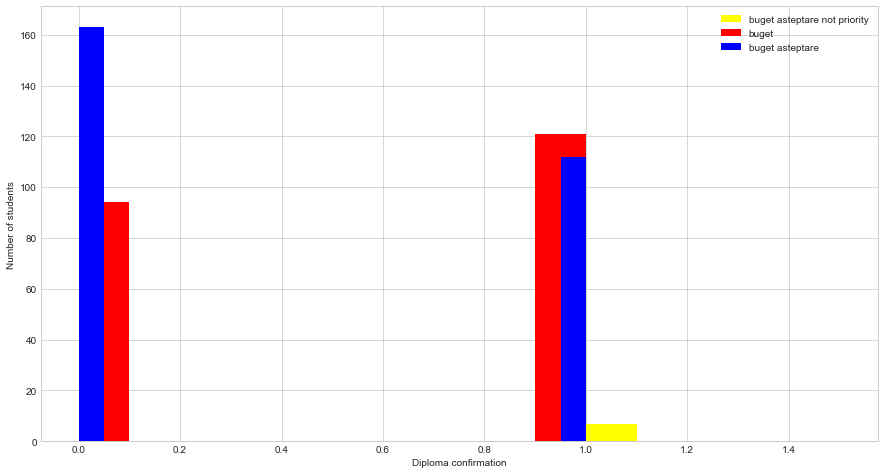

In [92]:
# Set the style
plt.style.use("seaborn-whitegrid")

fig = plt.figure(figsize=(15,8))
informatica_buget_asteptare_not_first_preference_df['confirmation'].plot.hist(color='yellow', label='buget asteptare not priority')
informatica_buget_df['confirmation'].plot.hist(color='red', label='buget')
informatica_buget_asteptare_df['confirmation'].plot.hist(bins=20, alpha=1, color='blue', label='buget asteptare')
plt.xlabel("Diploma confirmation")
plt.ylabel("Number of students")
plt.legend();

